<a href="https://colab.research.google.com/github/davidurpani/TimeSeriesAnalysisWithPython/blob/master/SKTIME_01_Forecasting_13Apr21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install pip -U

In [ ]:
!pip install sktime

In [ ]:
pip show sktime | grep Version

Version: 0.5.3


In [ ]:
#!pip install sktime[all_extras] -U

In [ ]:
!pip install pmdarima -U

Requirement already up-to-date: pmdarima in /usr/local/lib/python3.7/dist-packages (1.8.0)


In [83]:
#from sktime.forecasting.model_evaluation._functions import evaluate

In [ ]:
from warnings import simplefilter

import numpy as np
import pandas as pd

from sktime.datasets import load_airline
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    #MultiplexForecaster,
    TransformedTargetForecaster,
    #make_reduction,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
#from sktime.forecasting.model_evaluation import evaluate

from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

simplefilter("ignore", FutureWarning)
%matplotlib inline

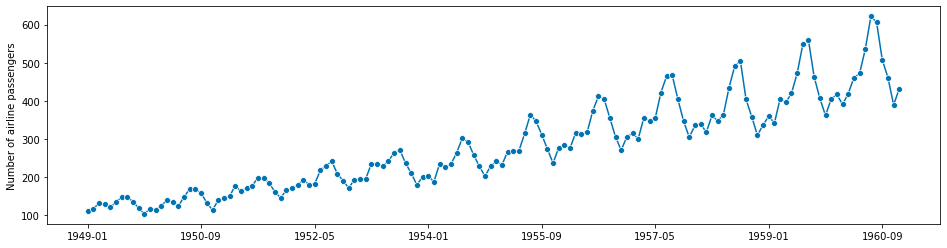

In [ ]:
y = load_airline()
plot_series(y);

## Specifying the forecasting task

Next we will define a forecasting task.

We will try to predict the last 3 years of data, using the previous years as training data. Each point in the series represents a month, so we should hold out the last 36 points as test data, and use 36-step ahead forecasting horizon to evaluate forecasting performance.
We will use the sMAPE (symmetric mean absolute percentage error) to quantify the accuracy of our forecasts. A lower sMAPE means higher accuracy.
We can split the data as follows:

108 36


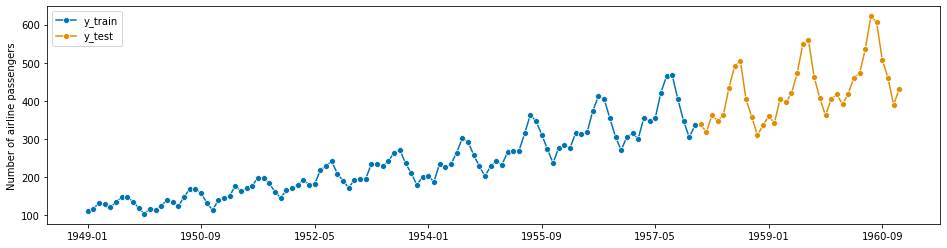

In [ ]:
y_train, y_test = temporal_train_test_split(y, test_size=36)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

When we want to generate forecasts, we need to specify the forecasting horizon and pass that to our forecasting algorithm.

Relative forecasting horizon

One of the simplest ways is to define a np.array with the steps ahead that you want to predict relative to the end of the training series.

In [ ]:
fh = np.arange(len(y_test)) + 1
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

So here we're interested in predicting from the first to to the 36th step ahead. Of course you could you use other forecasting horizons. For example, to predict only the second and fifth step ahead, you could write:

In [ ]:
fh = np.array([2, 5])  # 2nd and 5th step ahead

Absolute forecasting horizon

Alternatively, we can specify the forecasting horizon using the absolute time points we want to predict. In order to do that, we need to use sktime's ForecastingHorizon class. This way, we can simply create the forecasting horizon from the time points from the test set:

In [ ]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['1958-01', '1958-02', '1958-03', '1958-04', '1958-05', '1958-06',
             '1958-07', '1958-08', '1958-09', '1958-10', '1958-11', '1958-12',
             '1959-01', '1959-02', '1959-03', '1959-04', '1959-05', '1959-06',
             '1959-07', '1959-08', '1959-09', '1959-10', '1959-11', '1959-12',
             '1960-01', '1960-02', '1960-03', '1960-04', '1960-05', '1960-06',
             '1960-07', '1960-08', '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', name='Period', freq='M', is_relative=False)

# Generating forecasts

Like in scikit-learn, in order to make forecasts, we need to first specify (or build) a model, then fit it to the training data, and finally call predict to generate forecasts for the given forecasting horizon.

sktime comes with several forecasting algorithms (or forecasters) and tools for composite model building. All forecaster share a common interface. Forecasters are trained on a single series of data and make forecasts for the provided forecasting horizon.

**Naïve baselines**

Let's start with two naïve forecasting strategies which can serve as references for comparison of more sophisticated approaches.

Predicting the last value

0.2319577038795143

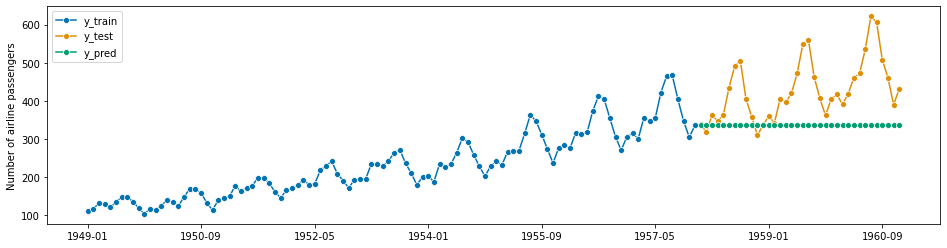

In [ ]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

Predicting the last value of the same season

0.145427686270316

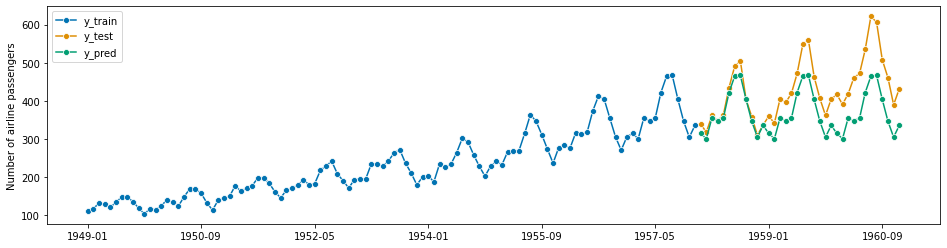

In [ ]:
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

## **Why not just use scikit-learn?**

You may wonder why we do not simply use scikit-learn for forecasting. Isn't forecasting in the end just a regression problem?

In principle, yes. But scikit-learn is not designed for solving forecasting tasks, so beware of the pitfalls!

**Pitfall 1: Model validation¶**

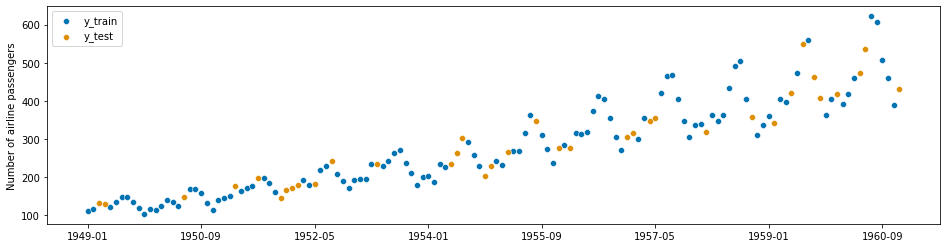

In [ ]:
from sklearn.model_selection import train_test_split

y_train, y_test = train_test_split(y)#, shuffle=False) Note: with shuffle=False temporal order is respected in the split
plot_series(y_train.sort_index(), y_test.sort_index(), labels=["y_train", "y_test"]);

This leads to leakage:

The data you are using to train a machine learning algorithm happens to have the information you are trying to predict.

### But train_test_split(y, shuffle=False) works, which is what temporal_train_test_split(y) does in sktime:

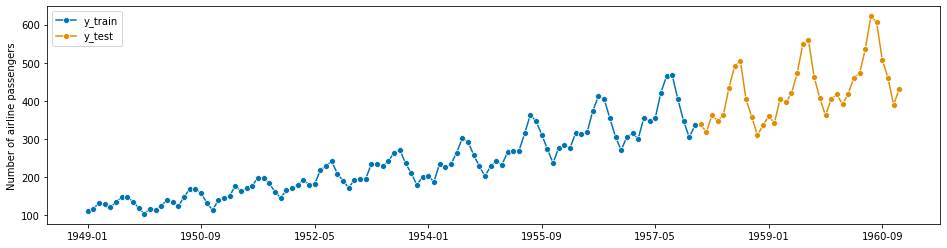

In [ ]:
y_train, y_test = temporal_train_test_split(y)
plot_series(y_train, y_test, labels=["y_train", "y_test"]);

## **Pitfall 2: How exactly do we apply regression algorithms to a forecasting task?**

In order to use scikit-learn, we have to first transform the data into the required tabular format, then fit a regressor and finally generate forecasts.

# Key idea: Reduction
Forecasting is often solved via regression. This approach is sometimes called reduction, because we reduce the forecasting task to the simpler but related task of tabular regression. This allows us to apply any regression algorithm to the forecasting problem.

Reduction to regression works as follows: We first need to transform the data into the required tabular format. We can do this by cutting the training series into windows of a fixed length and stacking them on top of each other. Our target variable consists of the subsequent observation for each window.

We could write some code to do that, as for example in the M4 competition:

In [ ]:
# slightly modified code from the M4 competition
def split_into_train_test(data, in_num, fh):
    """
    Splits the series into train and test sets.

    Each step takes multiple points as inputs
    :param data: an individual TS
    :param fh: number of out of sample points
    :param in_num: number of input points for the forecast
    :return:
    """
    train, test = data[:-fh], data[-(fh + in_num) :]
    x_train, y_train = train[:-1], np.roll(train, -in_num)[:-in_num]
    x_test, y_test = test[:-1], np.roll(test, -in_num)[:-in_num]
    #     x_test, y_test = train[-in_num:], np.roll(test, -in_num)[:-in_num]

    # reshape input to be [samples, time steps, features]
    # (N-NF samples, 1 time step, 1 feature)
    x_train = np.reshape(x_train, (-1, 1))
    x_test = np.reshape(x_test, (-1, 1))
    temp_test = np.roll(x_test, -1)
    temp_train = np.roll(x_train, -1)
    for x in range(1, in_num):
        x_train = np.concatenate((x_train[:-1], temp_train[:-1]), 1)
        x_test = np.concatenate((x_test[:-1], temp_test[:-1]), 1)
        temp_test = np.roll(temp_test, -1)[:-1]
        temp_train = np.roll(temp_train, -1)[:-1]

    return x_train, y_train, x_test, y_test

In [ ]:
# here we split the time index, rather than the actual values,
# to show how we split the windows
feature_window, target_window, _, _ = split_into_train_test(
    np.arange(len(y)), 10, len(fh)
)

To better understand the prior data transformation, we can look at how we can split the training series into windows. Here we show the generated windows expressed as integer indices:

In [ ]:
feature_window[:5, :]

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
       [ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
       [ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13]])

In [ ]:
target_window[:5]

array([10, 11, 12, 13, 14])

In [ ]:
# now we can split the actual values of the time series
x_train, y_train, x_test, y_test = split_into_train_test(y.values, 10, len(fh))
print(x_train.shape, y_train.shape)

(98, 10) (98,)


In [ ]:
x_test.shape, y_test.shape

((36, 10), (36,))

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

In [ ]:
model.score(x_test,y_test)

0.24726465978688728

In [ ]:
y_train[:10]

array([104., 118., 115., 126., 141., 135., 125., 149., 170., 170.])

In [ ]:
x_train[:10]

array([[112., 118., 132., 129., 121., 135., 148., 148., 136., 119.],
       [118., 132., 129., 121., 135., 148., 148., 136., 119., 104.],
       [132., 129., 121., 135., 148., 148., 136., 119., 104., 118.],
       [129., 121., 135., 148., 148., 136., 119., 104., 118., 115.],
       [121., 135., 148., 148., 136., 119., 104., 118., 115., 126.],
       [135., 148., 148., 136., 119., 104., 118., 115., 126., 141.],
       [148., 148., 136., 119., 104., 118., 115., 126., 141., 135.],
       [148., 136., 119., 104., 118., 115., 126., 141., 135., 125.],
       [136., 119., 104., 118., 115., 126., 141., 135., 125., 149.],
       [119., 104., 118., 115., 126., 141., 135., 125., 149., 170.]])

# What are potential pitfalls here?

This requires a lot of hand-written code which is often error-prone, not modular and not tuneable.

Note also that these steps involve a number of implicit hyper-parameters:

the way you slice the time series into windows (e.g. the window length)
the way you generate forecasts (recursive strategy, direct strategy, other hybrid strategies)

# Pitfall 3: Given a fitted regression algorithm, how can we generate forecasts?¶

In [ ]:
print(x_test.shape, y_test.shape)

# add back time index to y_test
y_test = pd.Series(y_test, index=y.index[-len(fh) :])

(36, 10) (36,)


In [ ]:
y_pred = model.predict(x_test)
smape_loss(pd.Series(y_pred, index=y_test.index), y_test)

0.11343355210783919

But what's the problem here?

We actually don't make a multi-step-ahead forecast up to the 36th step ahead. Instead, we make 36 single-step-ahead forecasts always using the most recent data. But that's a solution to a different learning task!

To fix this problem, we could write some code to do this recursively as in the M4 competition:

In [ ]:
# slightly modified code from the M4 study
predictions = []
last_window = x_train[-1, :].reshape(1, -1)  # make it into 2d array

last_prediction = model.predict(last_window)[0]  # take value from array

for i in range(len(fh)):
    # append prediction
    predictions.append(last_prediction)

    # update last window using previously predicted value
    last_window[0] = np.roll(last_window[0], -1)
    last_window[0, (len(last_window[0]) - 1)] = last_prediction

    # predict next step ahead
    last_prediction = model.predict(last_window)[0]

y_pred_rec = pd.Series(predictions, index=y_test.index)
smape_loss(y_pred_rec, y_test)

0.1510176663747095

# **Forecasting with sktime**

## Reduction: from forecasting to regression

sktime provides a meta-estimator for this approach, which is:

 - modular and compatible with scikit-learn, so that we can easily apply any scikit-learn regressor to solve our forecasting problem,

 - tuneable, allowing us to tune hyper-parameters like the window length or strategy to generate forecasts

 - adaptive, in the sense that it adapts the scikit-learn's estimator interface to that of a forecaster, making sure that we can tune and properly evaluate our model


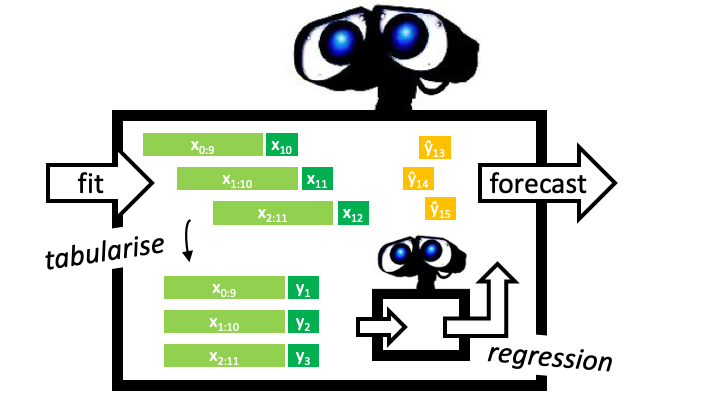

In [ ]:
# _reduce.py from github repository as from sktime.forecasting.compose._reduce
# import make_reduction
# does not find import
_author__ = ["Lovkush Agarwal", "Markus Löning"]
__all__ = [
    "make_reduction",
    "DirectTimeSeriesRegressionForecaster",
    "RecursiveTimeSeriesRegressionForecaster",
    "MultioutputTimeSeriesRegressionForecaster",
    "DirectTabularRegressionForecaster",
    "RecursiveTabularRegressionForecaster",
    "MultioutputTabularRegressionForecaster",
    "ReducedForecaster",
    "ReducedRegressionForecaster",
]

import numpy as np
from sklearn.base import RegressorMixin
from sklearn.base import clone

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.base._base import DEFAULT_ALPHA
from sktime.forecasting.base._sktime import _BaseWindowForecaster
from sktime.forecasting.base._sktime import _OptionalForecastingHorizonMixin
from sktime.forecasting.base._sktime import _RequiredForecastingHorizonMixin
from sktime.regression.base import BaseRegressor
from sktime.utils._maint import deprecated
from sktime.utils.validation import check_window_length
from sktime.utils.validation.forecasting import check_step_length


def _concat_y_X(y, X):
    """Helper function to concatenate y and X in preparation for sliding-window
    transform"""
    z = y.to_numpy()
    if z.ndim == 1:
        z = z.reshape(-1, 1)
    if X is not None:
        z = np.column_stack([z, X.to_numpy()])
    return z


def _check_fh(fh):
    """Helper function to check fh for sliding-window transform"""
    assert fh.is_relative
    assert fh.is_all_out_of_sample()
    return fh.to_indexer().to_numpy()


def _sliding_window_transform(
    y, window_length, fh, X=None, scitype="tabular-regressor"
):
    """Transform time series data `y` and `X` using sliding window.
    See `test_sliding_window_transform_explicit` in test_reduce.py for explicit
    example.
    Parameters
    ----------
    y : pd.Series
        Endogenous time series
    window_length : int
        Window length for transformed feature variables
    fh : ForecastingHorizon
        Forecasting horizon for transformed target variable
    X : pd.DataFrame, optional (default=None)
        Exogenous series.
    scitype : str {"tabular-regressor", "time-series-regressor"}, optional
        Scitype of estimator to use with transformed data.
        - If "tabular-regressor", returns X as tabular 2d array
        - If "time-series-regressor", returns X as panel 3d array
    Returns
    -------
    yt : np.ndarray, shape = (n_timepoints - window_length, 1)
        Transformed target variable.
    Xt : np.ndarray, shape = (n_timepoints - window_length, n_variables,
    window_length)
        Transformed lagged values of target variable and exogenous variables,
        excluding contemporaneous values.
    """
    # There are different ways to implement this transform. Pre-allocating an
    # array and filling it by iterating over the window length seems to be the most
    # efficient one.
    window_length = check_window_length(window_length)

    z = _concat_y_X(y, X)
    n_timepoints, n_variables = z.shape

    fh = _check_fh(fh)
    fh_max = fh[-1]

    if window_length + fh_max >= n_timepoints:
        raise ValueError(
            "The `window_length` and `fh` are incompatible with the length of `y`"
        )

    # Get the effective window length accounting for the forecasting horizon.
    effective_window_length = window_length + fh_max

    # Pre-allocate array for sliding windows.
    Zt = np.zeros(
        (
            n_timepoints + effective_window_length,
            n_variables,
            effective_window_length + 1,
        )
    )

    # Transform data.
    for k in range(effective_window_length + 1):
        i = effective_window_length - k
        j = n_timepoints + effective_window_length - k
        Zt[i:j, :, k] = z

    # Truncate data, selecting only full windows, discarding incomplete ones.
    Zt = Zt[effective_window_length:-effective_window_length]

    # Return transformed feature and target variables separately. This excludes
    # contemporaneous values of the exogenous variables. Including them would lead to
    # unequal-length data, with more time points for exogenous series than the target
    # series, which is currently not supported.
    yt = Zt[:, 0, window_length + fh]
    Xt = Zt[:, :, :window_length]

    # If the scitype is tabular regression, we have to convert X into a 2d array.
    if scitype == "tabular-regressor":
        return yt, Xt.reshape(Xt.shape[0], -1)
    else:
        return yt, Xt


class _Reducer(_BaseWindowForecaster):
    """Base class for reducing forecasting to time series regression"""

    _required_parameters = ["estimator"]

    def __init__(self, estimator, window_length=10, step_length=1):
        super(_Reducer, self).__init__(window_length=window_length)
        self.estimator = estimator
        self.step_length = step_length
        self.step_length_ = None
        self._cv = None

    def fit(self, y, X=None, fh=None):
        """Fit to training data.
        Parameters
        ----------
        y : pd.Series
            Target time series to which to fit the forecaster.
        X : pd.DataFrame, optional (default=None)
            Exogenous variables are ignored
        fh : int, list or np.array, optional (default=None)
            The forecasters horizon with the steps ahead to to predict.
        Returns
        -------
        self : returns an instance of self.
        """
        self._set_y_X(y, X)
        self._set_fh(fh)

        self.step_length_ = check_step_length(self.step_length)
        self.window_length_ = check_window_length(self.window_length)

        self._fit(y, X)
        self._is_fitted = True
        return self

    def _fit(self, y, X):
        raise NotImplementedError("abstract method")

    def _is_predictable(self, last_window):
        """Helper function to check if we can make predictions from last
        window"""
        return (
            len(last_window) == self.window_length_
            and np.sum(np.isnan(last_window)) == 0
            and np.sum(np.isinf(last_window)) == 0
        )

    def _predict_in_sample(self, fh, X=None, return_pred_int=False, alpha=None):
        # Note that we currently only support out-of-sample predictions. For the
        # direct and multioutput strategy, we need to check this already during fit,
        # as the fh is required for fitting.
        raise NotImplementedError(
            f"Generating in-sample predictions is not yet "
            f"implemented for {self.__class__.__name__}."
        )


class _DirectReducer(_RequiredForecastingHorizonMixin, _Reducer):
    strategy = "direct"

    def _transform(self, y, X=None):
        fh = self.fh.to_relative(self.cutoff)
        return _sliding_window_transform(
            y,
            window_length=self.window_length,
            fh=fh,
            X=X,
            scitype=self._estimator_scitype,
        )

    def _fit(self, y, X=None):
        """Fit to training data.
        Parameters
        ----------
        y : pd.Series
            Target time series to which to fit the forecaster.
        fh : int, list or np.array, optional (default=None)
            The forecasters horizon with the steps ahead to to predict.
        X : pd.DataFrame, optional (default=None)
            Exogenous variables are ignored
        Returns
        -------
        self : returns an instance of self.
        """
        # We currently only support out-of-sample predictions. For the direct
        # strategy, we need to check this at the beginning of fit, as the fh is
        # required for fitting.
        if not self.fh.is_all_out_of_sample(self.cutoff):
            raise NotImplementedError("In-sample predictions are not implemented.")

        yt, Xt = self._transform(y, X)

        # Iterate over forecasting horizon, fitting a separate estimator for each step.
        self.estimators_ = []
        for i in range(len(self.fh)):
            estimator = clone(self.estimator)
            estimator.fit(Xt, yt[:, i])
            self.estimators_.append(estimator)
        return self

    def _predict_last_window(
        self, fh, X=None, return_pred_int=False, alpha=DEFAULT_ALPHA
    ):
        # Get last window of available data.
        y_last, X_last = self._get_last_window()

        # If we cannot generate a prediction from the available data, return nan.
        if not self._is_predictable(y_last):
            return self._predict_nan(fh)

        if self._X is None:
            n_columns = 1
        else:
            # X is ignored here, since we currently only look at lagged values for
            # exogenous variables and not contemporaneous ones.
            n_columns = self._X.shape[1] + 1

        # Pre-allocate arrays.
        window_length = self.window_length_
        X_pred = np.zeros((1, n_columns, window_length))

        # Fill pre-allocated arrays with available data.
        X_pred[:, 0, :] = y_last
        if self._X is not None:
            X_pred[:, 1:, :] = X_last.T

        # We need to make sure that X has the same order as used in fit.
        if self._estimator_scitype == "tabular-regressor":
            X_pred = X_pred.reshape(1, -1)

        # Allocate array for predictions.
        y_pred = np.zeros(len(fh))

        # Iterate over estimators/forecast horizon
        for i, estimator in enumerate(self.estimators_):
            y_pred[i] = estimator.predict(X_pred)

        return y_pred


class _MultioutputReducer(_RequiredForecastingHorizonMixin, _Reducer):
    strategy = "multioutput"

    def _transform(self, y, X=None):
        fh = self.fh.to_relative(self.cutoff)
        return _sliding_window_transform(
            y,
            window_length=self.window_length,
            fh=fh,
            X=X,
            scitype=self._estimator_scitype,
        )

    def _fit(self, y, X=None):
        """Fit to training data.
        Parameters
        ----------
        y : pd.Series
            Target time series to which to fit the forecaster.
        fh : int, list or np.array, optional (default=None)
            The forecasters horizon with the steps ahead to to predict.
        X : pd.DataFrame, optional (default=None)
            Exogenous variables are ignored
        Returns
        -------
        self : returns an instance of self.
        """
        # We currently only support out-of-sample predictions. For the direct
        # strategy, we need to check this at the beginning of fit, as the fh is
        # required for fitting.
        if not self.fh.is_all_out_of_sample(self.cutoff):
            raise NotImplementedError("In-sample predictions are not implemented.")

        yt, Xt = self._transform(y, X)

        # Fit a multi-output estimator to the transformed data.
        self.estimator_ = clone(self.estimator)
        self.estimator_.fit(Xt, yt)
        return self

    def _predict_last_window(
        self, fh, X=None, return_pred_int=False, alpha=DEFAULT_ALPHA
    ):
        # Get last window of available data.
        y_last, X_last = self._get_last_window()

        # If we cannot generate a prediction from the available data, return nan.
        if not self._is_predictable(y_last):
            return self._predict_nan(fh)

        if self._X is None:
            n_columns = 1
        else:
            # X is ignored here, since we currently only look at lagged values for
            # exogenous variables and not contemporaneous ones.
            n_columns = self._X.shape[1] + 1

        # Pre-allocate arrays.
        window_length = self.window_length_
        X_pred = np.zeros((1, n_columns, window_length))

        # Fill pre-allocated arrays with available data.
        X_pred[:, 0, :] = y_last
        if self._X is not None:
            X_pred[:, 1:, :] = X_last.T

        # We need to make sure that X has the same order as used in fit.
        if self._estimator_scitype == "tabular-regressor":
            X_pred = X_pred.reshape(1, -1)

        # Iterate over estimators/forecast horizon
        y_pred = self.estimator_.predict(X_pred)
        return y_pred.ravel()


class _RecursiveReducer(_OptionalForecastingHorizonMixin, _Reducer):
    strategy = "recursive"

    def _transform(self, y, X=None):
        # For the recursive strategy, the forecasting horizon for the sliding-window
        # transform is simply a one-step ahead horizon, regardless of the horizon
        # used during prediction.
        fh = ForecastingHorizon([1])
        return _sliding_window_transform(
            y, self.window_length_, fh, X, scitype=self._estimator_scitype
        )

    def _fit(self, y, X):
        yt, Xt = self._transform(y, X)

        # Make sure yt is 1d array to avoid DataConversion warning from scikit-learn.
        yt = yt.ravel()

        self.estimator_ = clone(self.estimator)
        self.estimator_.fit(Xt, yt)
        return self

    def _predict_last_window(
        self, fh, X=None, return_pred_int=False, alpha=DEFAULT_ALPHA
    ):
        if self._X is not None and X is None:
            raise ValueError(
                "`X` must be passed to `predict` if `X` is given in `fit`."
            )

        # Get last window of available data.
        y_last, X_last = self._get_last_window()

        # If we cannot generate a prediction from the available data, return nan.
        if not self._is_predictable(y_last):
            return self._predict_nan(fh)

        # Pre-allocate arrays.
        if X is None:
            n_columns = 1
        else:
            n_columns = X.shape[1] + 1
        window_length = self.window_length_
        fh_max = fh.to_relative(self.cutoff)[-1]

        y_pred = np.zeros(fh_max)
        last = np.zeros((1, n_columns, window_length + fh_max))

        # Fill pre-allocated arrays with available data.
        last[:, 0, :window_length] = y_last
        if X is not None:
            last[:, 1:, :window_length] = X_last.T
            last[:, 1:, window_length:] = X.T

        # Recursively generate predictions by iterating over forecasting horizon.
        for i in range(fh_max):
            # Slice prediction window.
            X_pred = last[:, :, i : window_length + i]

            # Reshape data into tabular array.
            if self._estimator_scitype == "tabular-regressor":
                X_pred = X_pred.reshape(1, -1)

            # Generate predictions.
            y_pred[i] = self.estimator_.predict(X_pred)

            # Update last window with previous prediction.
            last[:, 0, window_length + i] = y_pred[i]

        # While the recursive strategy requires to generate predictions for all steps
        # until the furthest step in the forecasting horizon, we only return the
        # requested ones.
        fh_idx = fh.to_indexer(self.cutoff)
        return y_pred[fh_idx]


class DirectTabularRegressionForecaster(_DirectReducer):
    """
    Forecasting based on reduction to tabular regression using the direct
    strategy.
    For the direct reduction strategy, a separate forecaster is fitted
    for each step ahead of the forecasting horizon.
    Parameters
    ----------
    estimator : Estimator
        A tabular regression estimator as provided by scikit-learn.
    window_length : int, optional (default=10)
        The length of the sliding window used to transform the series into
        a tabular matrix.
    """

    _estimator_scitype = "tabular-regressor"


class MultioutputTabularRegressionForecaster(_MultioutputReducer):
    """
    Forecasting based on reduction to tabular regression using the multioutput
    strategy.
    For the multioutput strategy, a single estimator capable of handling multioutput
    targets is fitted to all the future steps in the forecasting horizon.
    Parameters
    ----------
    estimator : Estimator
        A tabular regression estimator as provided by scikit-learn.
    window_length : int, optional (default=10)
        The length of the sliding window used to transform the series into
        a tabular matrix.
    """

    _estimator_scitype = "tabular-regressor"


class RecursiveTabularRegressionForecaster(_RecursiveReducer):
    """
    Forecasting based on reduction to tabular regression using the recursive
    strategy.
    For the recursive strategy, a single estimator is fit for a one-step-ahead
    forecasting horizon and then called iteratively to predict multiple steps ahead.
    Parameters
    ----------
    estimator : Estimator
        A tabular regression estimator as provided by scikit-learn.
    window_length : int, optional (default=10)
        The length of the sliding window used to transform the series into
        a tabular matrix.
    """

    _estimator_scitype = "tabular-regressor"


class DirectTimeSeriesRegressionForecaster(_DirectReducer):
    """
    Forecasting based on reduction to time-series regression using the direct
    strategy.
    For the direct reduction strategy, a separate forecaster is fitted
    for each step ahead of the forecasting horizon.
    Parameters
    ----------
    estimator : Estimator
        A time-series regression estimator as provided by sktime.
    window_length : int, optional (default=10)
        The length of the sliding window used to transform the series into
        a tabular matrix.
    """

    _estimator_scitype = "time-series-regressor"


class MultioutputTimeSeriesRegressionForecaster(_MultioutputReducer):
    """
    Forecasting based on reduction to time series regression with a multioutput
    reduction strategy.
    For the multioutput strategy, a single estimator capable of handling multioutput
    targets is fitted to all the future steps in the forecasting horizon.
    Parameters
    ----------
    estimator : Estimator
        A time-series regression estimator as provided by sktime.
    window_length : int, optional (default=10)
        The length of the sliding window used to transform the series into
        a tabular matrix.
    """

    pass
    _estimator_scitype = "time-series-regressor"


class RecursiveTimeSeriesRegressionForecaster(_RecursiveReducer):
    """
    Forecasting based on reduction to time series regression with a recursive
    reduction strategy.
    For the recursive strategy, a single estimator is fit for a one-step-ahead
    forecasting horizon and then called iteratively to predict multiple steps ahead.
    Parameters
    ----------
    estimator : Estimator
        A time-series regression estimator as provided by sktime.
    window_length : int, optional (default=10)
        The length of the sliding window used to transform the series into
        a tabular matrix.
    """

    _estimator_scitype = "time-series-regressor"


@deprecated("Please use `make_reduction` from `sktime.forecasting.compose` instead.")
def ReducedForecaster(
    estimator, scitype="infer", strategy="recursive", window_length=10, step_length=1
):
    """
    Forecasting based on reduction.
    During fitting, a sliding-window approach is used to first transform the
    time series into tabular or panel data, which is then used to fit a tabular or
    time-series regression estimator. During prediction, the last available data is
    used as input to the fitted regression estimator to generate forecasts.
    Parameters
    ----------
    estimator : a estimator of type given by parameter scitype
    scitype : str {"infer", "tabular-regressor", "time-series-regressor"}
        Scitype of estimator.
    strategy : str {"recursive", "direct", "multioutput"}, optional
        Strategy to generate predictions
    window_length : int, optional (default=10)
    step_length : int, optional (default=1)
    References
    ----------
    ..[1] Bontempi, Gianluca & Ben Taieb, Souhaib & Le Borgne, Yann-Aël. (
    2013).
      Machine Learning Strategies for Time Series Forecasting.
    """
    if step_length != 1:
        raise ValueError(
            "`step_length` values different from 1 are no longer supported."
        )
    return make_reduction(
        estimator, strategy=strategy, window_length=window_length, scitype=scitype
    )


@deprecated("Please use `make_reduction` from `sktime.forecasting.compose` instead.")
def ReducedRegressionForecaster(
    estimator, scitype, strategy="recursive", window_length=10, step_length=1
):
    """
    Forecasting based on reduction.
    During fitting, a sliding-window approach is used to first transform the
    time series into tabular or panel data, which is then used to fit a tabular or
    time-series regression estimator. During prediction, the last available data is
    used as input to the fitted regression estimator to generate forecasts.
    Parameters
    ----------
    estimator : a estimator of type given by parameter scitype
    scitype : str {"infer", "tabular-regressor", "time-series-regressor"}
        Scitype of estimator.
    strategy : str {"recursive", "direct", "multioutput"}, optional
        Strategy to generate predictions
    window_length : int, optional (default=10)
    step_length : int, optional (default=1)
    References
    ----------
    ..[1] Bontempi, Gianluca & Ben Taieb, Souhaib & Le Borgne, Yann-Aël. (
    2013).
      Machine Learning Strategies for Time Series Forecasting.
    """
    if step_length != 1:
        raise ValueError(
            "`step_length` values different from 1 are no longer " "supported."
        )
    return make_reduction(
        estimator, strategy=strategy, window_length=window_length, scitype=scitype
    )


def make_reduction(
    estimator,
    strategy="recursive",
    window_length=10,
    scitype="infer",
):
    """
    Create a reduction forecaster based on a tabular or time-series regression
    estimator.
    During fitting, a sliding-window approach is used to first transform the
    time series into tabular or panel data, which is then used to fit a tabular or
    time-series regression estimator. During prediction, the last available data is
    used as input to the fitted regression estimator to generate forecasts.
    Parameters
    ----------
    estimator : an estimator instance
        Either a tabular regressor from scikit-learn or a time series regressor from
        sktime.
    strategy : str, optional (default="recursive")
        The strategy to generate forecasts. Must be one of "direct", "recursive" or
        "multioutput".
    window_length : int, optional (default=10)
        Window length used in sliding window transformation.
    scitype : str, optional (default="infer")
        Must be one of "infer", "tabular-regressor" or "time-series-regressor". If
        the scitype cannot be inferred, please specify it explicitly.
    Returns
    -------
    estimator : an Estimator instance
        A reduction forecaster
    References
    ----------
    ..[1] Bontempi, Gianluca & Ben Taieb, Souhaib & Le Borgne, Yann-Aël. (2013).
      Machine Learning Strategies for Time Series Forecasting.
    """
    # We provide this function as a factory method for user convenience.
    strategy = _check_strategy(strategy)
    scitype = _check_scitype(scitype)

    if scitype == "infer":
        scitype = _infer_scitype(estimator)

    Forecaster = _get_forecaster(scitype, strategy)
    return Forecaster(estimator=estimator, window_length=window_length)


def _check_scitype(scitype):
    valid_scitypes = ("infer", "tabular-regressor", "time-series-regressor")
    if scitype not in valid_scitypes:
        raise ValueError(
            f"Invalid `scitype`. `scitype` must be one of:"
            f" {valid_scitypes}, but found: {scitype}."
        )
    return scitype


def _infer_scitype(estimator):
    # We can check if estimator is an instance of scikit-learn's RegressorMixin or
    # of sktime's BaseRegressor, otherwise we raise an error. Note that some time-series
    # regressor also inherit from scikit-learn classes, hence the order in which we
    # check matters and we first need to check for BaseRegressor.
    if isinstance(estimator, BaseRegressor):
        return "time-series-regressor"
    elif isinstance(estimator, RegressorMixin):
        return "tabular-regressor"
    else:
        raise ValueError(
            "The `scitype` of the given `estimator` cannot be inferred. "
            "Please specify the `scitype` explicitly."
        )


def _check_strategy(strategy):
    valid_strategies = ("direct", "recursive", "multioutput")
    if strategy not in valid_strategies:
        raise ValueError(
            f"Invalid `strategy`. `strategy` must be one of :"
            f" {valid_strategies}, but found: {strategy}."
        )
    return strategy


def _get_forecaster(scitype, strategy):
    """Helper function to select forecaster for a given scientific type (
    scitype)
    and reduction strategy"""

    registry = {
        "tabular-regressor": {
            "direct": DirectTabularRegressionForecaster,
            "recursive": RecursiveTabularRegressionForecaster,
            "multioutput": MultioutputTabularRegressionForecaster,
        },
        "time-series-regressor": {
            "direct": DirectTimeSeriesRegressionForecaster,
            "recursive": RecursiveTimeSeriesRegressionForecaster,
            "multioutput": MultioutputTimeSeriesRegressionForecaster,
        },
    }
    return registry[scitype][strategy]

In [ ]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
print(y_train.shape[0], y_test.shape[0])

108 36


0.14187443909112035

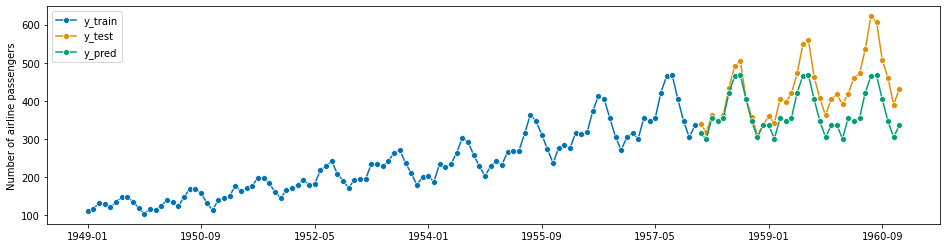

In [ ]:
#from sktime.forecasting.compose._reduce import make_reduction

from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

# **PROBLEM LOADING PACKAGE 'MAKE_REDUCTION' - SUBMUTTED QUERY TO USER GROUP - AWAITING RESPONSE - WED 14 APRIL 2020** (In the meantime have just cut and pasted the actual make_reduction code from github)

# Statistical forecasters

sktime has a number of statistical forecasting algorithms, based on implementations in statsmodels. For example, to use exponential smoothing with an additive trend component and multiplicative seasonality, we can write the following.

Note that since this is monthly data, the seasonal periodicity (sp), or the number of periods per year, is 12.

0.050276517173375584

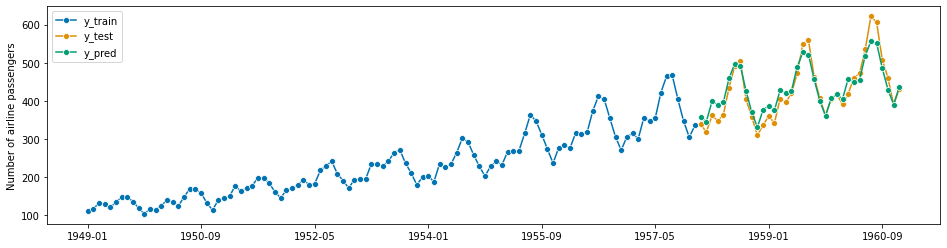

In [ ]:
forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

The exponential smoothing of state space model can also be automated similar to the ets function in R.



0.0631736567573623

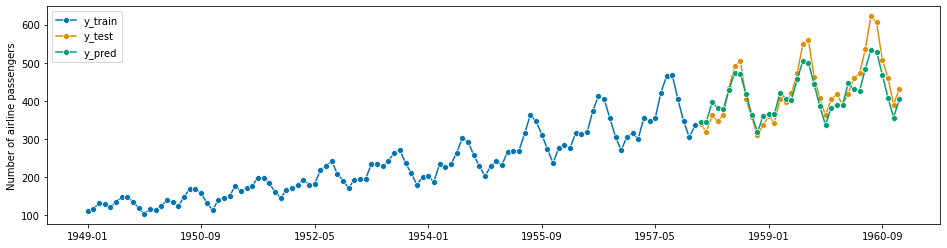

In [ ]:
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

Another common model is the ARIMA model. In sktime, we interface pmdarima, a package for automatically selecting the best ARIMA model. This earches over a number of possible model parametrisations, it may take a bit longer.

0.04117062369774064

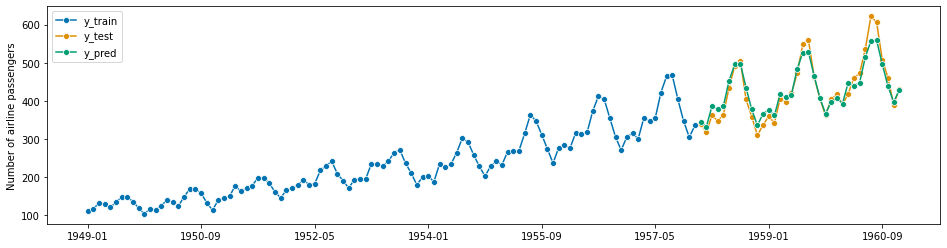

In [ ]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

A single ARIMA model can also be manually configured.

0.042571056664406505

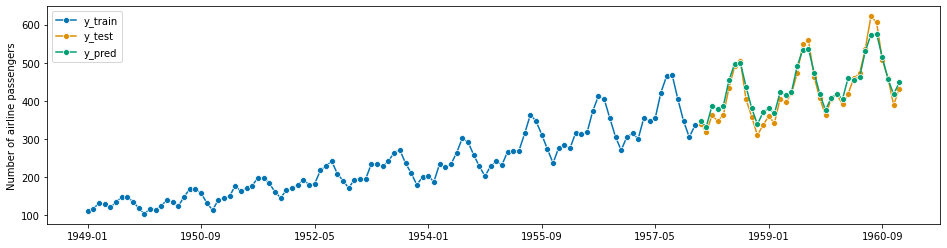

In [ ]:
forecaster = ARIMA(
    order=(1, 1, 0), seasonal_order=(0, 1, 0, 12), suppress_warnings=True
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

BATS and TBATS are two other time series forecasting algorithms that are contained in sktime by means of wrapping the package tbats.

In [ ]:
!pip install tbats

0.05887106960729719

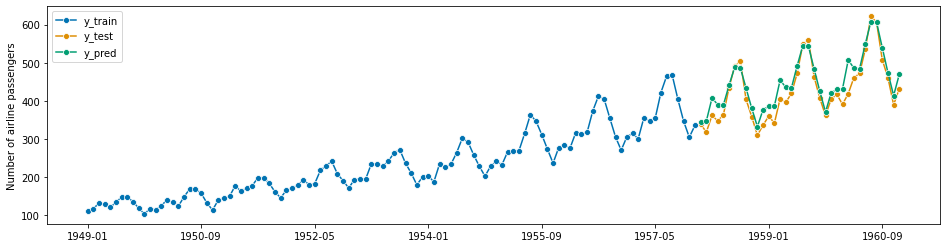

In [ ]:
from sktime.forecasting.bats import BATS

forecaster = BATS(sp=12, use_trend=True, use_box_cox=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

0.08493353477049947

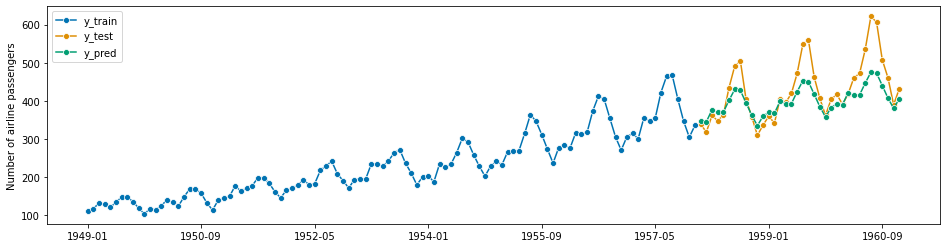

In [ ]:
from sktime.forecasting.tbats import TBATS

forecaster = TBATS(sp=12, use_trend=True, use_box_cox=False)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

0.05627907323688795

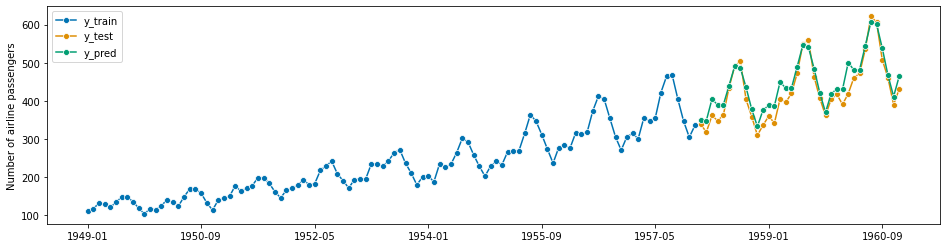

In [ ]:
from sktime.forecasting.tbats import TBATS

forecaster3 = TBATS(sp=12, use_trend=True, use_box_cox=True)
forecaster3.fit(y_train)
y_pred = forecaster3.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

sktime also provides an interface to fbprophet by Facebook. Please note that fbprophet is strongly related to data with a time stamp of type pd.DatetimeIndex, so we have to convert the index type first:



In [ ]:
# Convert index to pd.DatetimeIndex
z = y.copy()
z = z.to_timestamp(freq="M")
z_train, z_test = temporal_train_test_split(z, test_size=36)

0.06967488737663434

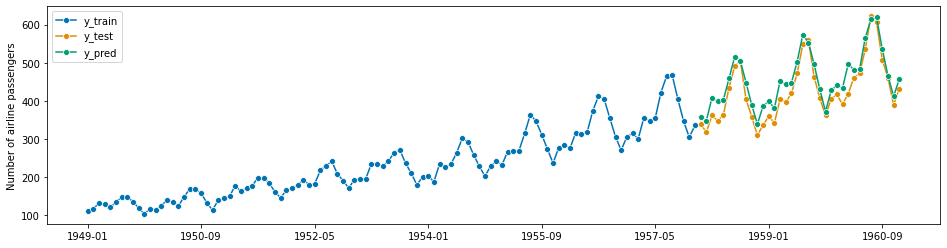

In [ ]:
from sktime.forecasting.fbprophet import Prophet

forecaster1 = Prophet(
    seasonality_mode="multiplicative",
    n_changepoints=int(len(y_train) / 12),
    add_country_holidays={"country_name": "Germany"},
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)
forecaster1.fit(z_train)
y_pred = forecaster1.predict(fh.to_relative(cutoff=y_train.index[-1]))

y_pred.index = y_test.index
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

# **Composite model building**

sktime provides a modular API for composite model building for forecasting.

# Ensembling

Like scikit-learn, sktime provides a meta-forecaster to ensemble multiple forecasting algorithms. For example, we can combine different variants of exponential smoothing as follows:

0.12994018798255688

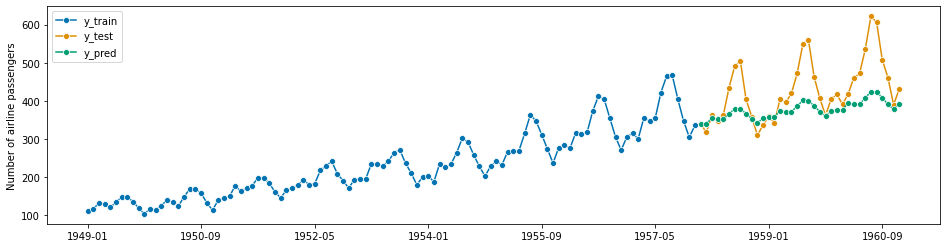

In [ ]:
ses = ExponentialSmoothing(sp=12)
holt = ExponentialSmoothing(trend="add", damped_trend=False, sp=12)
damped = ExponentialSmoothing(trend="add", damped_trend=True, sp=12)

forecaster = EnsembleForecaster(
    [
        ("ses", ses),
        ("holt", holt),
        ("damped", damped),
        ("TBATS", forecaster3)
    ]
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

# Tuning

In make_reduction, both the window_length and strategy arguments are hyper-parameters which we may want to optimise.

In [ ]:
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
param_grid = {"window_length": [5, 10, 12, 15, 25]}

# We fit the forecaster on the initial window, and then use temporal
# cross-validation to find the optimal parameter.
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)
gscv.fit(y_train)
y_pred = gscv.predict(fh)

0.14008272913734346

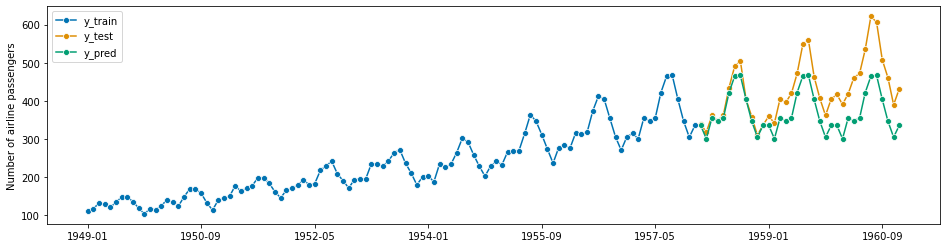

In [ ]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

In [ ]:
gscv.best_params_

{'window_length': 12}

# Tuning of wrapped regressor

Using scikit-learn's GridSearchCV, we can tune regressors imported from scikit-learn, in addition to tuning window_length.



0.12753485062532333

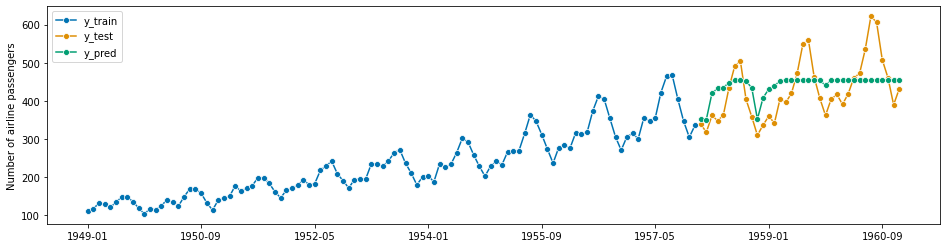

In [ ]:
from sklearn.model_selection import GridSearchCV

# tuning the 'n_estimator' hyperparameter of RandomForestRegressor from scikit-learn
regressor_param_grid = {"n_estimators": [100, 200, 300]}
forecaster_param_grid = {"window_length": [7, 12, 15]}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(RandomForestRegressor(), param_grid=regressor_param_grid)
forecaster = make_reduction(
    regressor, scitype="tabular-regressor", strategy="recursive"
)

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=18)
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

In [ ]:
print(gscv.best_params_, gscv.best_forecaster_.estimator_.best_params_)

{'window_length': 12} {'n_estimators': 300}


To access performance on a particular metric during tuning, we can use the scoring argument of ForecastingGridSearchCV.

In [ ]:
gscv = ForecastingGridSearchCV(
    forecaster, cv=cv, param_grid=forecaster_param_grid, scoring=sMAPE()
)
gscv.fit(y_train)
pd.DataFrame(gscv.cv_results_)

,mean_fit_time,mean_score_time,param_window_length,params,mean_test_sMAPE,rank_test_sMAPE
0,4.419638,0.644280,7,{'window_length': 7},0.155044,3
1,4.434120,0.450594,12,{'window_length': 12},0.089299,1
2,4.675138,0.468675,15,{'window_length': 15},0.094542,2


# Automatic model selection using tuning plus multiplexer

For model selection, 'MultiplexForecaster' is recommended to be used with 'ForecastingGridSearchCV'. Individually, 'MultiplexForecaster' takes different sktime forecasters wrapped in argument 'forecasters' and with the argument 'selected_forecaster', it selects which forecaster to fit when 'fit' is called. The real benefit of Multiplexer is achieved When 'MultiplexForecaster' is used in conjunction with 'ForecastingGridSearchCV'. The 'selected_forecaster' argument becomes an hyperparameter of 'MultiplexForecaster'. This way 'ForecastingGridSearchCV' provides a frame for MultiplexForecaster to switch between different forecasters to find the best performing one given a training data.

The 'forecasters' argument of 'MultiplexForecaster' can take in any sktime forecaster. The functionality provided by 'MultiplexForecaster' can even be stretched by providing 'ForecastingGridSearchCV's with different estimators wrapped in 'forecasters'. This way, the process will first tune the hyperparameters of each forecaster and then return the best performing forecaster. This way, a pipeline of hyperparameter tunning and model selection can be processed by 'MultiplexForecaster'. Finally, 'MultiplexForecaster' can work with any tuner as well, since it is an sktime forecaster.

In [ ]:
#MultiplexForecaster code from github (as a workaround as import fails!)
#!/usr/bin/env python3 -u
# -*- coding: utf-8 -*-
# copyright: sktime developers, BSD-3-Clause License (see LICENSE file)

from sktime.forecasting.base._meta import _HeterogenousEnsembleForecaster
from sktime.forecasting.base._base import DEFAULT_ALPHA
from sktime.forecasting.base._sktime import _OptionalForecastingHorizonMixin
from sklearn.base import clone

__author__ = ["Kutay Koralturk"]
__all__ = ["MultiplexForecaster"]


class MultiplexForecaster(
    _OptionalForecastingHorizonMixin, _HeterogenousEnsembleForecaster
):
    def __init__(
        self,
        forecasters: list,
        selected_forecaster=None,
    ):

        """
        MultiplexForecaster facilitates a framework for performing
        model selection process over different model classes.
        It should be used in conjunction with ForecastingGridSearchCV
        to get full utilization.
        Single use of MultiplexForecaster with forecasters
        and selected_forecaster parameter specified,
        works just like the selected component.
        It does not provide any further use in that case.
        When used with ForecastingGridSearchCV, MultiplexForecaster
        provides an ability to compare different model class
        performances with each other, just like a model tournament.
        When ForecastingGridSearchCV is fitted with a MultiplexForecaster,
        returned value for the selected_forecaster argument of best_params_
        attribute of ForecastingGridSearchCV, gives the best
        performing model class among given models provided in forecasters.
        Parameters
        ----------
        forecasters : list
            List of (forecaster names, forecaster objects)
            MultiplexForecaster switches between these forecasters
            objects when used with ForecastingGridSearchCV to
            find the optimal model
        selected_forecaster: str
            An argument to make a selection among forecasters.
            MultiplexForecaster uses selected_forecaster
            to choose which component to fit.
            Important for using with ForecastingGridSearchCV as a
            hyperparameter.
        Attributes
        ----------
        _forecaster : Sktime forecaster
            forecaster that MultiplexForecaster will currently
            forecast with.
        """

        super(MultiplexForecaster, self).__init__(forecasters=forecasters, n_jobs=None)
        self.selected_forecaster = selected_forecaster
        self._forecaster = None

    def _check_fit_params(self, fit_params):
        forecaster_fit_params = {}

        if self.selected_forecaster is None or fit_params == {}:
            return forecaster_fit_params

        for component in self.forecasters:
            name, _ = component
            if name not in fit_params.keys():
                raise KeyError(
                    "If you provide fit_params for models "
                    "dictionary key of fit params need to "
                    " match the associated component key."
                )

        if self.selected_forecaster in fit_params.keys():
            forecaster_fit_params = fit_params[self.selected_forecaster]
            return forecaster_fit_params
        else:
            return forecaster_fit_params

    def _check_selected_forecaster(self):
        component_names = [name for name, _ in self.forecasters]
        if self.selected_forecaster not in component_names:
            raise Exception(
                "Please check the selected_forecaster argument provided "
                " Valid selected_forecaster parameters: {}".format(component_names)
            )

    def _set_forecaster(self):
        self._check_selected_forecaster()
        if self.selected_forecaster is not None:
            for name, forecaster in self.forecasters:
                if self.selected_forecaster == name:
                    self._forecaster = clone(forecaster)

    def fit(self, y, X=None, fh=None, **fit_params):
        """Fit to training data.
        Parameters
        ----------
        y : pd.Series
            Target time series to which to fit the forecaster.
        fh : int, list or np.array, optional (default=None)
            The forecasters horizon with the steps ahead to to predict.
        X : pd.DataFrame, optional (default=None)
            Exogenous variables are ignored
        fit_params : dict
            A dictionary composed of key-value pairs
            of forecaster names and fit params to be
            used for each forecaster.
            Example: {"ARIMA": ..., "ETS": ...}
        Returns
        -------
        self : returns an instance of self.
        """

        self._set_y_X(y, X)
        self._set_fh(fh)
        self._check_forecasters()
        self._set_forecaster()
        forecaster_fit_params = self._check_fit_params(fit_params=fit_params)
        self._forecaster.fit(y, X=X, fh=fh, **forecaster_fit_params)
        self._is_fitted = True
        return self

    def _predict(self, fh, X=None, return_pred_int=False, alpha=DEFAULT_ALPHA):
        return self._forecaster.predict(
            fh, X, return_pred_int=return_pred_int, alpha=alpha
        )

    def update(self, y, X=None, update_params=True):
        """Call predict on the forecaster with the best found parameters. """
        self.check_is_fitted()
        self._update_y_X(y, X)
        self._forecaster.update(y, X, update_params=update_params)
        return self

In [ ]:
forecaster = MultiplexForecaster(
    forecasters=[
        ("naive", NaiveForecaster(strategy="last")),
        ("tbats", TBATS(sp=12, use_trend=True, use_box_cox=False)),
        ("ets", ExponentialSmoothing(trend="add", sp=12)),
    ]
)
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=10)
forecaster_param_grid = {"selected_forecaster": ["ets", "naive","tbats"]}
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

gscv.fit(y_train)
y_pred = gscv.predict(fh)

For a single update, you can use the update method.

0.12753485062532333

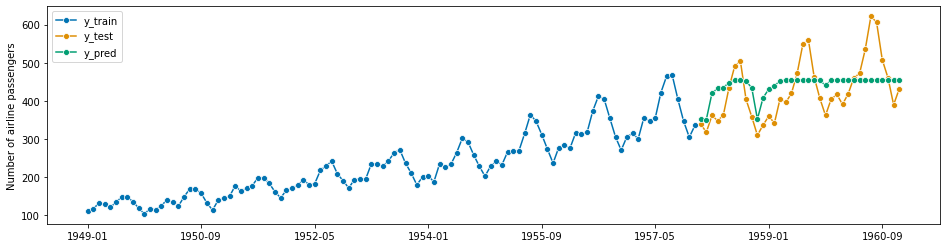

In [ ]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

In [ ]:
gscv = ForecastingGridSearchCV(
    forecaster, cv=cv, param_grid=forecaster_param_grid, scoring=sMAPE()
)
gscv.fit(y_train)
pd.DataFrame(gscv.cv_results_)

,mean_fit_time,mean_score_time,param_window_length,params,mean_test_sMAPE,rank_test_sMAPE
0,4.503138,0.567353,7,{'window_length': 7},0.154481,3
1,4.396768,0.297295,12,{'window_length': 12},0.089092,1
2,4.458280,0.325513,15,{'window_length': 15},0.096734,2


In [ ]:
print(gscv.best_params_, "\n", gscv.best_forecaster_)

{'window_length': 12} 
 RecursiveTabularRegressionForecaster(estimator=GridSearchCV(estimator=RandomForestRegressor(),
                                                            param_grid={'n_estimators': [100,
                                                                                         200,
                                                                                         300]}),
                                     window_length=12)


# Detrending

Note that so far the reduction approach above does not take any seasonal or trend into account, but we can easily specify a pipeline which first detrends the data.

sktime provides a generic detrender, a transformer which uses any forecaster and returns the in-sample residuals of the forecaster's predicted values. For example, to remove the linear trend of a time series, we can write:

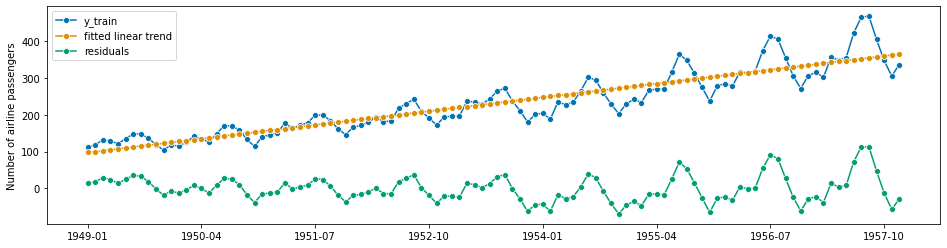

In [ ]:
# liner detrending
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
yt = transformer.fit_transform(y_train)

# internally, the Detrender uses the in-sample predictions
# of the PolynomialTrendForecaster
forecaster = PolynomialTrendForecaster(degree=1)
fh_ins = -np.arange(len(y_train))  # in-sample forecasting horizon
y_pred = forecaster.fit(y_train).predict(fh=fh_ins)

plot_series(y_train, y_pred, yt, labels=["y_train", "fitted linear trend", "residuals"]);

# Pipelining

Let's use the detrender in a pipeline together with de-seasonalisation. Note that in forecasting, when we apply data transformations before fitting, we need to apply the inverse transformation to the predicted values. For this purpose, we provide the following pipeline class:

0.054817449147330055

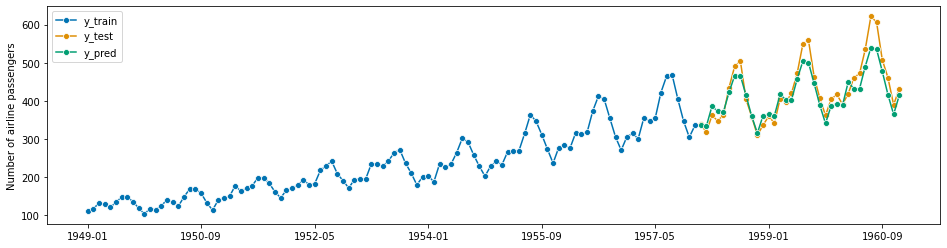

In [ ]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        (
            "forecast",
            make_reduction(
                regressor,
                scitype="tabular-regressor",
                window_length=12,
                strategy="recursive",
            ),
        ),
    ]
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

Of course, we could try again to optimise the hyper-parameters of components of the pipeline.

Below we discuss two other aspects of forecasting: online learning, where we want to dynamically update forecasts as new data comes in, and prediction intervals, which allow us to quantify the uncertainty of our forecasts.

# Online Forecasting

For model evaluation, we sometimes want to evaluate multiple forecasts, using temporal cross-validation with a sliding window over the test data. For this purpose, we can leverage the forecasters from the online_forecasting module which use a composite forecaster, PredictionWeightedEnsemble, to keep track of the loss accumulated by each forecaster and create a prediction weighted by the predictions of the most "accurate" forecasters.

Note that the forecasting task is changed: we make 35 predictions since we need the first prediction to help update the weights, we do not predict 36 steps ahead.



In [ ]:
from sklearn.metrics import mean_squared_error

from sktime.forecasting.online_learning import (
    NormalHedgeEnsemble,
    OnlineEnsembleForecaster,
)

First we need to initialize a PredictionWeightedEnsembler that will keep track of the loss accumulated by each forecaster and define which loss function we would like to use.

In [ ]:
hedge_expert = NormalHedgeEnsemble(n_estimators=3, loss_func=mean_squared_error)

We can then create the forecaster by defining the individual forecasters and specifying the PredictionWeightedEnsembler we are using. Then by fitting our forecasters and performing updates and prediction with the update_predict function, we get:

0.15073283888658456

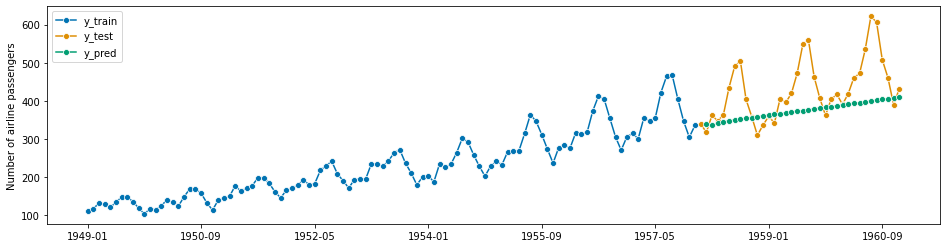

In [ ]:
forecaster = OnlineEnsembleForecaster(
    [
        ("ses", ses),
        ("holt", holt),
        ("damped", damped),
    ],
    ensemble_algorithm=hedge_expert,
)

forecaster.fit(y_train)
y_pred = forecaster.update_predict(y_test)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test[1:], y_pred)

# Prediction intervals

So far, we've only looked at point forecasts. In many cases, we're also interested in prediction intervals. sktime's interface support prediction intervals, but we haven't implemented them for all algorithms yet.

Here, we use the Theta forecasting algorithm:

In [ ]:
forecaster = ThetaForecaster(sp=12)
forecaster.fit(y_train)
alpha = 0.10  # 95% prediction intervals
y_pred, pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)
smape_loss(y_test, y_pred)

0.08661467760556908

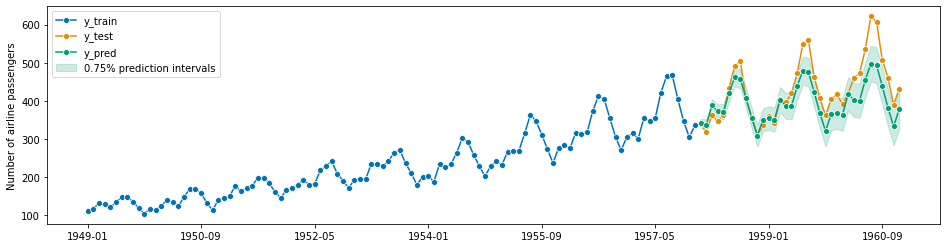

In [ ]:
fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    pred_ints["lower"],
    pred_ints["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();

# Model evaluation for forecasting (backtesting)

In forecasting, we usually want to know how well a forecaster would have performed in the past. This goes beyond a simple train-test-split because we want to backtest multiple fit/updates on different data. A forecaster evaluation consists at least of...

forecaster that can also be a ForecastingGridSearchCV or EnsembleForecaster
cv of e.g. ExpandingWindowSplitter or SlidingWindowSplitter
strategy wether the forecaster should be always be refitted or just fitted once and then updated

In [103]:
# -*- coding: utf-8 -*-

__author__ = ["Martin Walter", "Markus Löning"]
__all__ = ["evaluate"]

import numpy as np
import pandas as pd
import time
from sktime.utils.validation.forecasting import check_y_X
from sktime.utils.validation.forecasting import check_cv
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.validation.forecasting import check_scoring, check_fh


def evaluate(
    forecaster,
    cv,
    y,
    X=None,
    strategy="refit",
    scoring=None,
    fit_params=None,
    return_data=False,
):
    """Evaluate forecaster using cross-validation
    Parameters
    ----------
    forecaster : sktime.forecaster
        Any forecaster
    y : pd.Series
        Target time series to which to fit the forecaster.
    X : pd.DataFrame, optional (default=None)
        Exogenous variables
    cv : Temporal cross-validation splitter
        Splitter of how to split the data into test data and train data
    strategy : str, optional (default="refit")
        Must be "refit" or "update". The strategy defines whether the `forecaster` is
        only fitted on the first train window data and then updated, or always refitted.
    scoring : object of class MetricFunctionWrapper from
        sktime.performance_metrics, optional. Example scoring=sMAPE().
        Used to get a score function that takes y_pred and y_test as arguments,
        by default None (if None, uses sMAPE)
    fit_params : dict, optional (default=None)
        Parameters passed to the `fit` call of the forecaster.
    return_data : bool, optional
        Returns three additional columns in the DataFrame, by default False.
        The cells of the columns contain each a pd.Series for y_train,
        y_pred, y_test.
    Returns
    -------
    pd.DataFrame
        DataFrame that contains several columns with information regarding each
        refit/update and prediction of the forecaster.
    Examples
    --------
    >>> from sktime.datasets import load_airline
    >>> from sktime.forecasting.model_evaluation import evaluate
    >>> from sktime.forecasting.model_selection import ExpandingWindowSplitter
    >>> from sktime.forecasting.naive import NaiveForecaster
    >>> y = load_airline()
    >>> forecaster = NaiveForecaster(strategy="mean", sp=12)
    >>> cv = ExpandingWindowSplitter(initial_window=24, step_length=12,
    ...                              fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    >>> results = evaluate(forecaster=forecaster, y=y, cv=cv)
    """
    _check_strategy(strategy)
    cv = check_cv(cv, enforce_start_with_window=True)
    
    scoring = check_scoring(scoring)
    y, X = check_y_X(y, X)
    fit_params = {} if fit_params is None else fit_params

    # Define score name.
    score_name = "test_" + scoring.name

    # Initialize dataframe.
    results = pd.DataFrame()

    # Run temporal cross-validation.
    for i, (train, test) in enumerate(cv.split(y)):
        # split data
        y_train, y_test, X_train, X_test = _split(y, X, train, test, cv.fh)

        # create forecasting horizon
        fh = ForecastingHorizon(y_test.index, is_relative=False)

        # fit/update
        start_fit = time.time()
        if i == 0 or strategy == "refit":
            forecaster.fit(y_train, X_train, fh=fh, **fit_params)

        else:  # if strategy == "update":
            forecaster.update(y_train, X_train)
        fit_time = time.time() - start_fit

        # predict
        start_pred = time.time()
        y_pred = forecaster.predict(fh, X=X_test)
        pred_time = time.time() - start_pred

        # score
        score = scoring(y_pred, y_test)

        # save results
        results = results.append(
            {
                score_name: score,
                "fit_time": fit_time,
                "pred_time": pred_time,
                "len_train_window": len(y_train),
                "cutoff": forecaster.cutoff,
                "y_train": y_train if return_data else np.nan,
                "y_test": y_test if return_data else np.nan,
                "y_pred": y_pred if return_data else np.nan,
            },
            ignore_index=True,
        )

    # post-processing of results
    if not return_data:
        results = results.drop(columns=["y_train", "y_test", "y_pred"])
    results["len_train_window"] = results["len_train_window"].astype(int)

    return results


def _split(y, X, train, test, fh):
    """Split y and X for given train and test set indices"""
    y_train = y.iloc[train]
    y_test = y.iloc[test]

    cutoff = y_train.index[-1]
    fh = check_fh(fh)
    fh = fh.to_relative(cutoff)

    if X is not None:
        X_train = X.iloc[train, :]

        # We need to expand test indices to a full range, since some forecasters
        # require the full range of exogenous values.
        test = np.arange(test[0] - fh.min(), test[-1]) + 1
        X_test = X.iloc[test, :]
    else:
        X_train = None
        X_test = None

    return y_train, y_test, X_train, X_test


def _check_strategy(strategy):
    """Assert strategy value
    Parameters
    ----------
    strategy : str
        strategy of how to evaluate a forecaster
    Raises
    ------
    ValueError
        If strategy value is not in expected values, raise error.
    """
    valid_strategies = ("refit", "update")
    if strategy not in valid_strategies:
        raise ValueError(f"`strategy` must be one of {valid_strategies}")


In [104]:
def check_cv(cv, enforce_start_with_window=False):
    """
    Check CV generators.
    Parameters
    ----------
    cv : CV generator
    Raises
    ------
    ValueError
        if cv does not have the required attributes.
    """
    from sktime.forecasting.model_selection._split import BaseSplitter

    if not isinstance(cv, BaseSplitter):
        raise TypeError(f"`cv` is not an instance of {BaseSplitter}")

    if enforce_start_with_window:
        if hasattr(cv, "start_with_window") and not cv.start_with_window:
            raise ValueError("`start_with_window` must be set to True")

    return cv

In [105]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
cv = ExpandingWindowSplitter(
    step_length=12, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], initial_window=72
)

df = evaluate(forecaster=forecaster, y=y, cv=cv, strategy="refit", return_data=True)
df.iloc[:, :5]

ValueError: ignored

def check_cv(cv, enforce_start_with_window=False):